# Introduction

The accurate policy evalutation is important: if the expected return (i.e., sum of future rewards) given a particular policy cannot be correctly evaluated, then policy would not be able to improve (Sutton and Barto, Chapter $4$).  

The naive value function assumes all agents follow a **static** joint policy in the future. 
This assumption is often violated in multiagent settings as the other agents are also learning agents, so they have **non-stationary** policies in the future.  

Consequently, we empirically prove in this notebook that the naive value function fails to estimate the expected reutrn accurately, and further show that **if an agent considers further future policies of its peers, then the agent has more accurate policy evaluation**.

# Experiment Overview

## Domain

The hallway environment (refer to LeCTR) with $2$ agents is considered for the experiment:  
* There are $n$ states in the domain.
* Each agent has $2$ actions: whether to move right/left at each state.
* Agents receive +1 if and only if one agent is at the beginning of the hallway and the other agent is located at the end of the hallway. Then, the game terminates (i.e., terminal state).
* Otherwise, agents receive +0.

## Policy

* Agent $1$ has a random policy: selects either action with probability of $0.5$.
* Agent $2$ has a time-varying policy: $p(a^{2}_{t}=Left)$ and $p(a^{2}_{t}=Right)$ linearly decreases and increases, respectively, over time.

## Comparisons:

* **True** return: Monte-carlo sampling is applied with many independent runs (e.g., $100$ runs), which closely approximate the true return with many samples.

* Naive learning: $V^{1}_{\pi_{t}}(s_{t})=\sum_{{a_t}\in\mathcal{A}}\pi_{t}^{1}(a^{1}_{t}|s_{t})\pi^2_{t}(a^2_{t}|s_{t})\sum_{s_{t+1}\in\mathcal{S}}\mathcal{T}(s_{t+1}|s_{t},a_{t})\Big[R^1(s_{t},a^{i}_{t})+\gamma V^{1}_{\pi_t}(s_{t+1})\Big]$

* Ours (1-step look-ahead): $V^{1}_{\pi_{t}}(s_{t})=\sum_{{a_t}\in\mathcal{A}}\pi^{1}_{t}(a^{1}_{t}|s_{t})\pi^{2}_{t}(a^{2}_{t}|s_{t})\sum_{s_{t+1}\in\mathcal{S}}\mathcal{T}(s_{t+1}|s_{t},a_{t})\Bigg[R^1(s_{t},a_{t})+\gamma \Bigg[\sum_{{a_{t+1}}\in\mathcal{A}}\pi^{1}_{t+1}(a^1_{t+1}|s_{t+1})\pi^{2}_{t+1}(a^{2}_{t+1}|s_{t+1})\sum_{s_{t+2}\in\mathcal{S}}\mathcal{T}(s_{t+2}|s_{t+1},a_{t+1})\Big[R^{1}(s_{t+1},a_{t+1})+\gamma V^{1}_{\pi_{t+1}}(s_{t+2})\Bigg]\Bigg]$

* Ours (2-step look-ahead): $V^{1}_{\pi_{t}}(s_{t})=\sum_{{a_t}\in\mathcal{A}}\pi^{1}_{t}(a^{1}_{t}|s_{t})\pi^{2}_{t}(a^{2}_{t}|s_{t})\sum_{s_{t+1}\in\mathcal{S}}\mathcal{T}(s_{t+1}|s_{t},a_{t})\Bigg[R^1(s_{t},a_{t})+\gamma \Bigg[\sum_{{a_{t+1}}\in\mathcal{A}}\pi^{1}_{t+1}(a^1_{t+1}|s_{t+1})\pi^{2}_{t+1}(a^{2}_{t+1}|s_{t+1})\sum_{s_{t+2}\in\mathcal{S}}\mathcal{T}(s_{t+2}|s_{t+1},a_{t+1})\Bigg[R^{1}(s_{t+1},a_{t+1})+\gamma \Big[\sum_{{a_{t+2}}\in\mathcal{A}}\pi^{1}_{t+2}(a^1_{t+2}|s_{t+2})\pi^{2}_{t+2}(a^{2}_{t+2}|s_{t+2})\sum_{s_{t+3}\in\mathcal{S}}\mathcal{T}(s_{t+3}|s_{t+2},a_{t+2})\Big[R^{1}(s_{t+2},a_{t+2})+\gamma V^{1}_{\pi_{t+2}}(s_{t+3})\Big]\Big]\Bigg]\Bigg]$

* Ours (N-step look-ahead): Continue to replace the value function on the right hand side with N-future policies

## Assumptions
As dynamic programming is used to do the policy evaluation, the followings are assummed:
* Access to a model of an environment: state space, action space, transition function, reward function
* Access to opponent's policy and its future policies

# Result

Please run *_train.sh* which will automatically run and save results in the "data/" folder.

## Visualization of true return

In [1]:
# Setup path
import os, sys
sys.path.append(os.path.dirname(os.path.abspath('')))

# Import libraries
import numpy as np
from misc.vis import vis

# Read true return (montecarlo) data
true_return = np.load("../data/montecarlo_100.npy")
vis(true_return)

<Figure size 640x480 with 1 Axes>

## Difference compared to the ground-truth
We perform dynamic programming for each method, train until converges, and then compare to the true return.


In [2]:
# Naive comparison
naive = np.load("../data/naive_100.npy")
naive_diff = np.sum((true_return - naive).flatten())
print("Naive diff: {:.5f}".format(naive_diff))

# Ours comparison
ours_diffs = []
n_lookaheads = [n for n in range(1,10)]
for n in n_lookaheads:
    ours = np.load("../data/ours_100_" + str(n) + ".npy")
    ours_diff = np.sum((true_return - ours).flatten())
    print("Ours diff : {:.5f} at lookahead {}".format(ours_diff, n))
    ours_diffs.append(ours_diff)

Naive diff: 1.91077
Ours diff : 1.90692 at lookahead 1
Ours diff : 1.89932 at lookahead 2
Ours diff : 1.88655 at lookahead 3
Ours diff : 1.86871 at lookahead 4
Ours diff : 1.84578 at lookahead 5
Ours diff : 1.81791 at lookahead 6
Ours diff : 1.78509 at lookahead 7
Ours diff : 1.74743 at lookahead 8
Ours diff : 1.70497 at lookahead 9


Text(0,0.5,'Difference between true expected return')

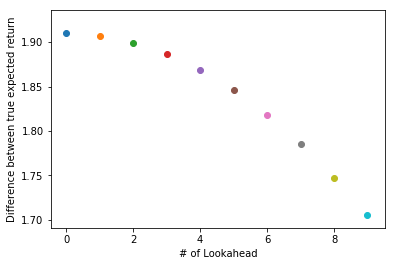

In [3]:
# Additionally plot
import matplotlib.pyplot as plt

n_lookaheads = [n for n in range(10)]
for n in n_lookaheads:
    # Naive plot
    if n == 0:
        plt.scatter(n, naive_diff)
    # ours plot
    else:
        plt.scatter(n, ours_diffs[n - 1])
        
plt.xlabel("# of Lookahead")
plt.ylabel("Difference between true expected return")